In [16]:
import numpy as np
import qiskit.pulse as pulse
from qiskit.quantum_info.operators import Operator
from qiskit_dynamics import Solver
from matplotlib import pyplot as plt
from qiskit_dynamics.pulse import InstructionToSignals
from qiskit.quantum_info.states import Statevector
from scipy.integrate import cumulative_trapezoid
from scipy.optimize import root_scalar

这份文件实现了任意角度RX旋转门的实现，设计了指定角度，在确定的sig下寻找gaussian wave的amp。但是实验上amp与sigma的关系未知。

In [17]:
# Start the qubit in its ground state.
y0 = Statevector([1., 0.])

# Strength of the Rabi-rate in GHz.
r = 2*np.pi*0.1

# Frequency of the qubit transition in GHz.
w = 5.

# Sample rate of the backend in ns.
dt = 1 / 4.5

# construct operators
X = Operator.from_label('X')
Y = Operator.from_label('Y')
Z = Operator.from_label('Z')

#持续时间
T = 50 * dt
#持续duration个采样间隔
duration = int(T / dt)


drift = 2 * np.pi * w * Z/2
#H0
operators = [r * Y]
#Hd

# construct the solver
hamiltonian_solver = Solver(
    static_hamiltonian=drift,
    hamiltonian_operators=operators,
    rotating_frame=drift,
    rwa_cutoff_freq=2*w,
    hamiltonian_channels=['d0'],
    channel_carrier_freqs={'d0': w},
    dt=dt
)

In [18]:
def PlotEnveAndGetSignal(dt,xp,draw=False):
    converter = InstructionToSignals(dt, carriers={"d0": w})
    signals = converter.get_signals(xp)
    if (draw):
        plt.rcParams["font.size"] = 16
        fig, axs = plt.subplots(1, 2, figsize=(14, 4.5))
        for ax, title in zip(axs, ["envelope", "signal"]):
            signals[0].draw(0, 2*T, 2000, title, axis=ax)
            ax.set_xlabel("Time (ns)")
            ax.set_ylabel("Amplitude")
            ax.set_title(title)
    return signals
        
def plot_populations(sol):
    pop0 = [psi.probabilities()[0] for psi in sol.y]
    pop1 = [psi.probabilities()[1] for psi in sol.y]

    fig = plt.figure(figsize=(8, 5))
    plt.plot(sol.t, pop0, lw=3, label="Population in |0>")
    plt.plot(sol.t, pop1, lw=3, label="Population in |1>")
    plt.xlabel("Time (ns)")
    plt.ylabel("Population")
    plt.legend(frameon=False)
    plt.ylim([0, 1.05])
    plt.xlim([0, 2*T])
    plt.vlines(T, 0, 1.05, "k", linestyle="dashed")
    
def GetFinalState(sol):
    cos = np.linalg.norm(sol.y[-1][0])
    sin = np.linalg.norm(sol.y[-1][1])
    print("the final state is: ",sol.y[-1])
    print("the rotation angle is: ",np.arctan(sin/cos))


In [19]:
def PrintAngle(signals,t_list):
    envelope=signals[0].envelope
    values = envelope(t_list)
    integral = cumulative_trapezoid(values, x=t_list, initial=0)
    return integral[-1]*r/2
    #R(a/2)->sin(a/2)
    
def FindGaussianAngle(target,duration, amp_ini,sig,t_list):
    left = 0; right = 1; amp = amp_ini
    for i in range(100):
        with pulse.build(name="sx-sy schedule") as xp:
            pulse.play(pulse.Gaussian(duration, amp,sig), pulse.DriveChannel(0))
        signal = PlotEnveAndGetSignal(dt,xp)
        Angle = PrintAngle(signal,t_list)
        if (Angle-target>0.001):
            right = amp; amp = (right+left)/2
        elif (target-Angle>0.001):
            left = amp; amp = (right+left)/2
        else: return amp
        #print(Angle)
    return -1

In [20]:
Target_Angle = np.pi/2
amp = 0.6
sig = 15
#积分的取点位置
t_list= np.linspace(0,T,1000)
Target_Amp= FindGaussianAngle(Target_Angle,duration,0.5,sig,t_list)
print("the amp is: ",FindGaussianAngle(Target_Angle,duration,0.5,sig,t_list))

the amp is:  0.763671875


CPU times: total: 10.7 s
Wall time: 10.9 s


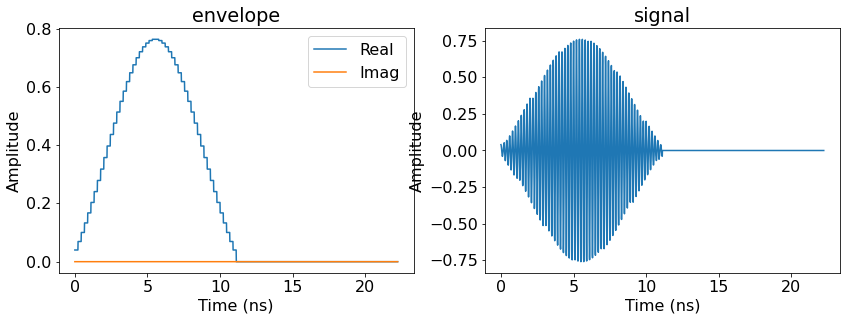

In [21]:
with pulse.build(name="sx-sy schedule") as xp:
    pulse.play(pulse.Gaussian(duration,Target_Amp,sig), pulse.DriveChannel(0))
    
xp.draw()

signal = PlotEnveAndGetSignal(dt,xp,True)
%time sol = hamiltonian_solver.solve(t_span=[0., 2*T], y0=y0, signals=signal, atol=1e-8, rtol=1e-8)

the final state is:  Statevector([0.00186811+5.12954965e-16j, 0.99999826+2.70681623e-15j],
            dims=(2,))
the rotation angle is:  1.568928220182516


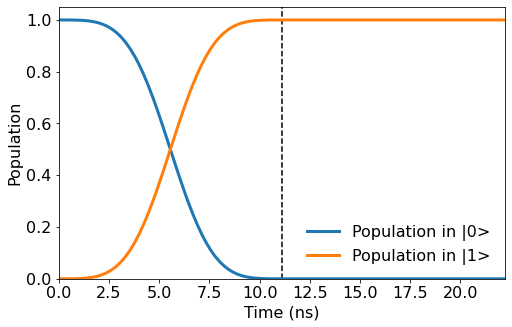

In [22]:
GetFinalState(sol)
plot_populations(sol)
#缺了波形优化这个部分，实际上不需要用二分法寻找amp，而是以保真度为损失函数计算amp